### Model recovery


In [1]:
import pyabc
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc.transition import Transition, MultivariateNormalTransition
from pyabc.weighted_statistics import weighted_quantile

models = ['basic',  'gradedmugo', 'scaledguessing', 'fullabcd']

def get_db(generator):
    assert generator in models
    modelstring = '_'.join(models)
    history = pyabc.History(f'sqlite:///results/generative_{generator}_{modelstring}_adaptive_distance.db')
    assert history.id is not None
    print(history.id)
    print(history.model_names())
    return(history)

def plot_model_probabilities(db, generator):
    basic_prob = db.get_model_probabilities()
    plt.figure(figsize=(6,4))
    plt.plot(basic_prob)
    plt.xlabel('populations')
    plt.ylabel('Model probability')
    plt.legend(models)
    plt.title(f'Generating model: {generator}')

def get_model_parameters():
    parameters = {}
    for model in models:
        with open(f'params/params_{model}.json') as f:
            parameters[model] = json.load(f)
    return(parameters)

In [2]:
parameters = get_model_parameters()


1
['fit_transform', 'fit_transform', 'fit_transform', 'fit_transform']
1
['fit_transform', 'fit_transform', 'fit_transform', 'fit_transform']
1
['fit_transform', 'fit_transform', 'fit_transform', 'fit_transform']
1
['fit_transform', 'fit_transform', 'fit_transform', 'fit_transform']


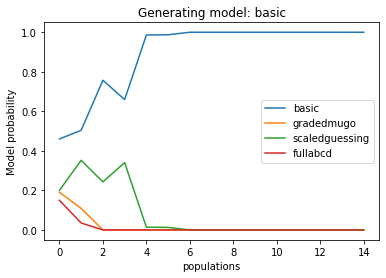

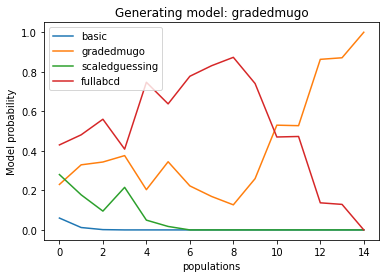

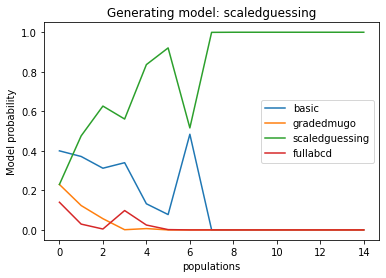

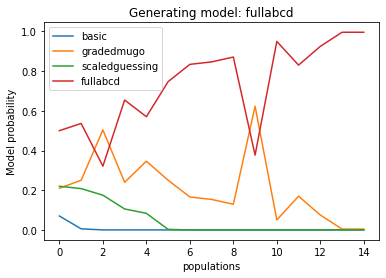

In [3]:
db = {}
for model in models:
    db[model] = get_db(model)
    plot_model_probabilities(db[model], model)

## Compare estimated parameters to generating parameters

In [4]:

# get estimates using kde
model = 'basic'
modelnum = 0

def get_model_parameters(history, modelnum):
    df, w = history.get_distribution(m=modelnum, t=history.max_t)
    par_names = list(df.columns.values)
    n_par = len(par_names)

    # adapted from pyabc.plot_credible_intervals
    median = {}

    df, w = db[model].get_distribution(m=modelnum, t=db[model].max_t)
    # normalize weights to be sure
    w /= w.sum()
    # iterate over parameters
    for i_par, par in enumerate(par_names):
        # as numpy array
        vals = np.array(df[par])
        # median
        median[par] = weighted_quantile(vals, w, alpha=0.5)

    return(median)

def get_true_parameters(params):
    # get matching parameters for model
    return({
        'mu_go': params['mu']['go'],
        'mu_stop_delta': params['mu']['stop'] - params['mu']['go'],
        'mu_delta_incorrect': params['mu_delta_incorrect'],
        'nondecision': params['nondecision']['go'],
        'noise_sd': params['noise_sd']['go']})
    
df = {}
trueparams = {}
estparams = {}
for modelnum, model in enumerate(models):
    print('Generating model:', model)
    trueparams[model] = get_true_parameters(parameters[model])
    estparams[model] = get_model_parameters(db[model], modelnum)
    df[model] = pd.DataFrame({'true':trueparams[model], 'estimated':estparams[model]})
    print(df[model])
    modelprobs = db[model].get_model_probabilities()
    modelprobs.columns = models
    print()
    print('model posterior probabilities')
    print(modelprobs.iloc[db[model].max_t, :])
    print()

Generating model: basic
                    true  estimated
mu_go                0.3   0.165028
mu_stop_delta        0.2   0.018889
mu_delta_incorrect   0.2   0.100485
nondecision         50.0  64.855923
noise_sd             2.2   2.447662

model posterior probabilities
basic             1.0
gradedmugo        0.0
scaledguessing    0.0
fullabcd          0.0
Name: 14, dtype: float64

Generating model: gradedmugo
                    true  estimated
mu_go                0.3   0.164805
mu_stop_delta        0.2   0.038039
mu_delta_incorrect   0.2   0.051361
nondecision         50.0  63.646075
noise_sd             2.2   2.578000

model posterior probabilities
basic             0.0
gradedmugo        1.0
scaledguessing    0.0
fullabcd          0.0
Name: 14, dtype: float64

Generating model: scaledguessing
                    true  estimated
mu_go                0.3   0.168630
mu_stop_delta        0.2   0.012633
mu_delta_incorrect   0.2   0.109929
nondecision         50.0  59.391093
noise_sd    

In [17]:
## Compare true results to estimated results

from stopsignalmodel import StopSignalModel

results_df = {}
ssd_df = {}
for modelnum, model in enumerate(models):

    ssm = StopSignalModel(model, parameters=parameters[model])
    sim_results = ssm.fit_transform(estparams[model])

    observed_data = ssm.fit_transform(trueparams[model])
    results_df[model] = pd.DataFrame(columns=['simulation', 'data'])

    for k in sim_results:
        if not k.find('presp')>-1 and not k.find('accuracy')>-1:
            # print(k, simulation[k], observed_data[k])
            results_df[model].loc[k] = [sim_results[k], observed_data[k]]
    
    ssdvals = np.arange(0, 501, 50)

    ssd_df[model] = pd.DataFrame(
        columns=['SSD', 'presp_true', 'presp_fitted', 'accuracy_true', 'accuracy_fitted'])
    for i, ssd in enumerate(ssdvals):
        ssd_df[model].loc[i, :] = [
            ssd,
            observed_data[f'presp_{i}'],
            sim_results[f'presp_{i}'],
            observed_data[f'accuracy_{i}'],
            sim_results[f'accuracy_{i}'],
        ]

    print()
    print('Model:', model)
    print('Simulated vs observed results:')
    print(results_df[model])



Model: basic
Simulated vs observed results:
                  simulation        data
mean_go_RT        491.332277  357.459500
mean_stopfail_RT  456.855285  325.919426
go_acc              0.844691    0.940000
sd_go_RT          175.205556  115.576292
sd_stopfail_RT    157.050755   91.194215

Model: gradedmugo
Simulated vs observed results:
                  simulation        data
mean_go_RT        492.591879  355.513257
mean_stopfail_RT  493.684449  389.960582
go_acc              0.848516    0.923462
sd_go_RT          182.577774  116.082627
sd_stopfail_RT    172.836829  109.635247

Model: scaledguessing
Simulated vs observed results:
                  simulation        data
mean_go_RT        471.463971  353.953000
mean_stopfail_RT  403.648032  318.515542
go_acc              0.821669    0.929500
sd_go_RT          176.164734  114.673082
sd_stopfail_RT    160.859024  102.603378

Model: fullabcd
Simulated vs observed results:
                  simulation        data
mean_go_RT        449.84

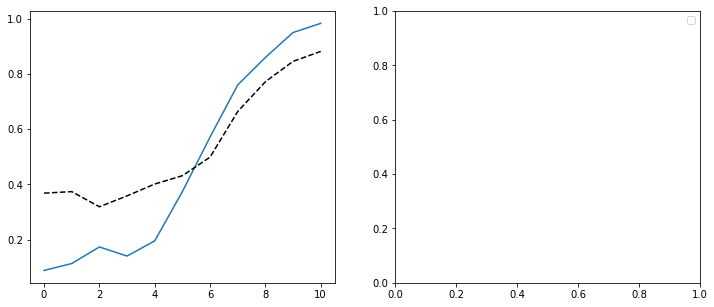

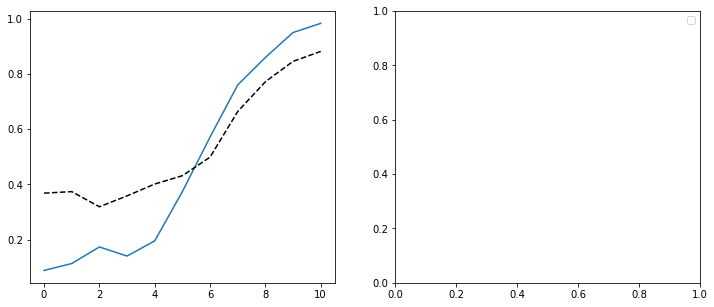

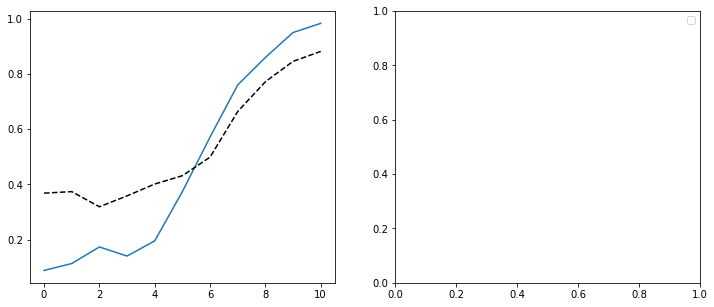

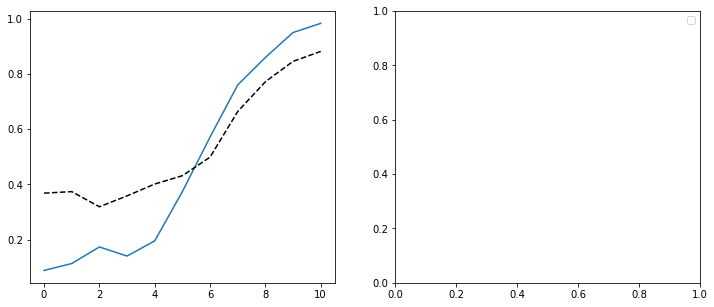

In [16]:
for m in models:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5),
                           title=f'generating model: {model}')
    ax[0].plot(ssd_df[model].SSD, ssd_df[model].presp_true)
    ax[0].plot(ssd_df[model].SSD, ssd_df[model].presp_fitted, 'k--')
    plt.legend(['true', 'fitted'])
    plt.ylim(0, 1)
    plt.ylabel()
